In [0]:
import os
!rm -rf *
!rm -rf .kaggle/
!git clone https://github.com/bkahn-github/data-science-bowl.git
!pip install -r data-science-bowl/requirements.txt
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install Pillow
!pip install click
!mkdir ~/.kaggle
f = open(".kaggle/kaggle.json", "w")
f.write('{"username":"bkkaggle","key":"bf4e62680116284087ace0484990f87a"}')
f.close()
!kaggle competitions download -c data-science-bowl-2018
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train.zip -d ~/.kaggle/competitions/data-science-bowl-2018/stage1_train
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_test.zip -d ~/.kaggle/competitions/data-science-bowl-2018/stage1_test
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train_labels.csv.zip -d ~/.kaggle/competitions/data-science-bowl-2018/
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_sample_submission.csv.zip -d ~/.kaggle/competitions/data-science-bowl-2018/

In [0]:
import os
os.chdir('data-science-bowl/pytorchMultiOutputUnet/')
!git checkout multioutput-unet

Branch multioutput-unet set up to track remote branch multioutput-unet from origin.
Switched to a new branch 'multioutput-unet'


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1qRwtzTiY72JEv5MKSL58yHyZwayKFRhZ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('model-15.pt')

In [0]:
!python main.py subset --subset=False preprocess

In [0]:
!python main.py subset --subset=False train --epochs=15 --weights='./model-15.pt'

In [0]:
import os
import click
import logging
from tqdm import tqdm

import torch
import torchvision

from torch.utils.data import DataLoader

import skimage.morphology

from config import config
from create_masks import create_masks
from loaders import TrainDataset, x_transforms, y_transforms
from model import Unet
from utils import get_ids
from metrics import dice_loss

import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

config.SUBSET = False

model2 = Unet()
model2.load_state_dict(torch.load('model-15.pt'))
model2.eval()
model2.cuda()

In [0]:
import matplotlib.pyplot as plt

def visualize():
  
  ids = get_ids()
  
  train = TrainDataset(ids, x_transform=x_transforms, y_transform=y_transforms)
  trainDataloader = DataLoader(train, batch_size=config.BATCH_SIZE, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)

  for data in trainDataloader:
    img, target = data['img'], data['target']

    x = Variable(img).cuda()
    y = Variable(target).cuda()

    outs = model2(x)
    break
  
  x = x.data.cpu().numpy()
  masks = outs[:,0].data.cpu().numpy()
  contours = outs[:,1].data.cpu().numpy()
  centers = outs[:,2].data.cpu().numpy()
  
  fig = plt.figure(figsize=(20, 10))
  
  ax = plt.subplot("241")
  ax.set_title(str(x[0].min()) + ' ' + str(x[0].max()))
  ax.imshow(x[0].reshape(256, 256, 3)*0.5+0.5)

  ax = plt.subplot("242")
  ax.set_title(str(masks[0].min()) + ' ' + str(masks[0].max()))
  ax.imshow(masks[0])

  ax = plt.subplot("243")
  ax.set_title(str(masks[0].min()) + ' ' + str(masks[0].max()))
  ax.imshow((masks[0] > 0.5))

  ax = plt.subplot("244")
  lab_img = skimage.morphology.label(masks[0] > 0.5)
  ax.set_title(str(lab_img.min()) + ' ' + str(lab_img.max()))
  ax.imshow(lab_img.reshape(256, 256))
  
  ax = plt.subplot("245")
  ax.set_title(str(contours[0].min()) + ' ' + str(contours[0].max()))
  ax.imshow((contours[0]))

  ax = plt.subplot("246")
  ax.set_title(str(contours[0].min()) + ' ' + str(contours[0].max()))
  ax.imshow((contours[0] > 0.5))

  ax = plt.subplot("247")
  ax.set_title(str(centers[0].min()) + ' ' + str(centers[0].max()))
  ax.imshow((centers[0]))

  ax = plt.subplot("248")
  ax.set_title(str(centers[0].min()) + ' ' + str(centers[0].max()))
  ax.imshow((centers[0] > 0.5))


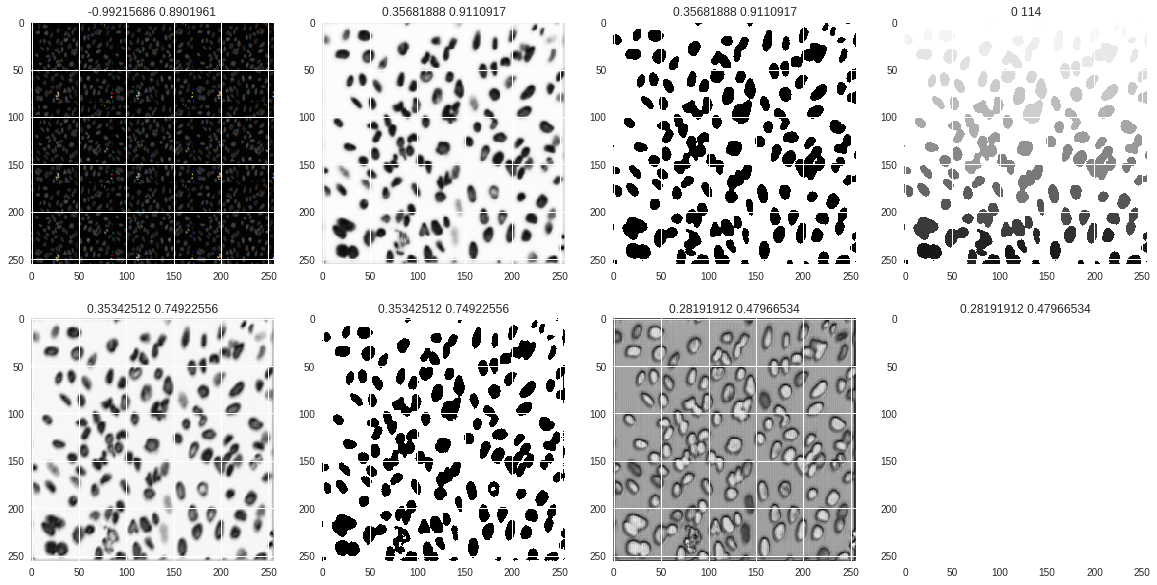

In [0]:
visualize()

In [0]:
ids = get_ids()

train = TrainDataset(ids, x_transform=x_transforms, y_transform=y_transforms)
trainDataloader = DataLoader(train, batch_size=config.BATCH_SIZE, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)

for data in trainDataloader:
  img, target = data['img'], data['target']

  x = Variable(img).cuda()
  y = Variable(target).cuda()

  outs = model2(x)
  break

In [0]:
y = y.data.cpu().numpy()
outs = outs.data.cpu().numpy()

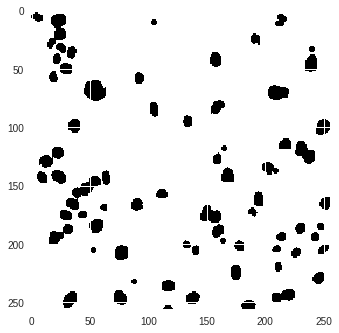

In [0]:
plt.imshow(y[1][0].reshape(256, 256))

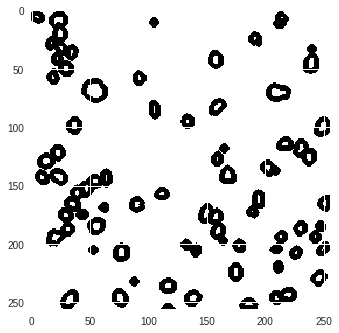

In [0]:
plt.imshow(y[1][1].reshape(256, 256))

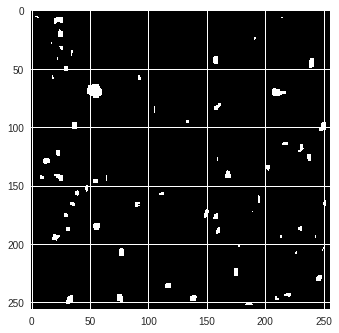

In [0]:
plt.imshow((((y[1][0] - y[1][1]) > 0) * -1).reshape(256, 256))

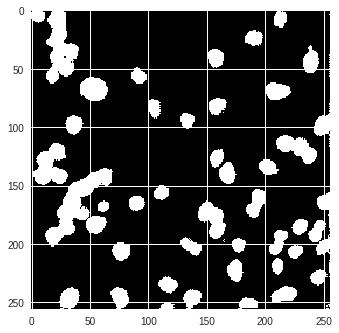

In [0]:
plt.imshow((outs[1][0] < 0.5).reshape(256, 256))

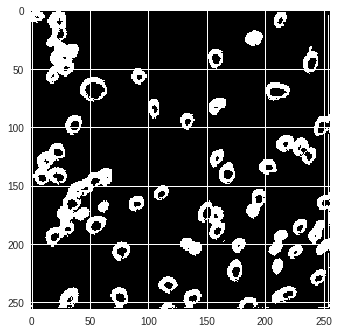

In [0]:
plt.imshow((outs[1][1] < 0.5).reshape(256, 256))

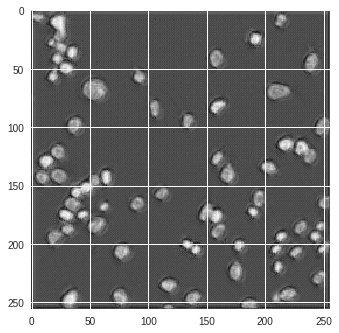

In [0]:
plt.imshow(((((outs[1][0]) - (outs[1][1]))) * -1).reshape(256, 256))

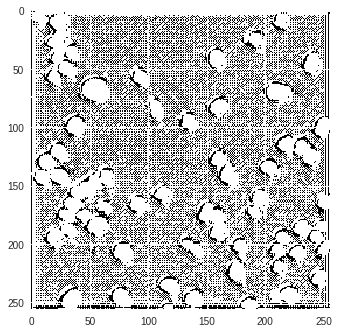

In [0]:
plt.imshow(((((outs[1][0]) - (outs[1][1])) > 0) * -1).reshape(256, 256))

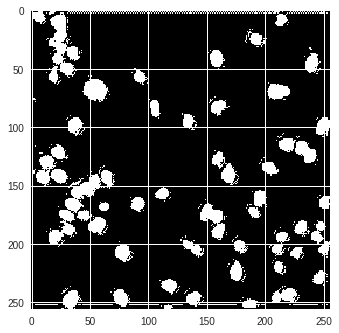

In [0]:
plt.imshow(((((outs[1][0]) - (outs[1][1])) > 0.03) * -1).reshape(256, 256))

In [0]:
import os
import glob
import numpy as np

import torch
import torchvision

from utils import get_ids, get_path

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform
from PIL import Image

id = get_ids()[0]

img_path, mask_path, contour_path, center_path = get_path(id)

img = Image.open(img_path)
img.load()

RGBimg = Image.new("RGB", img.size, (255, 255, 255))
RGBimg.paste(img, mask=img.split()[3])

img = np.array(RGBimg)

mask = io.imread(mask_path)
contour = io.imread(contour_path)
center = io.imread(center_path)

mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
contour = contour.reshape(contour.shape[0], contour.shape[1], 1)
center = center.reshape(center.shape[0], center.shape[1], 1)

target = np.concatenate((mask, contour, center), axis=-1)

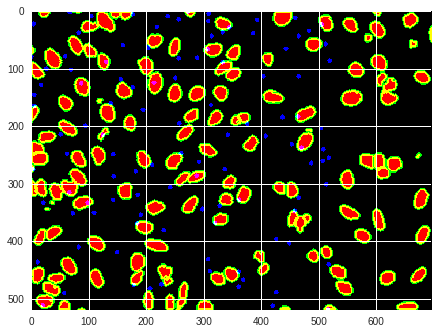

In [0]:
plt.imshow(target)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

uploaded = drive.CreateFile({'title': 'pytorch-multioutput-unet-29-epochs'})
uploaded.SetContentFile('model-29.pt')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
!kill -9 -1